In [16]:
import pandas as pd
import numpy as np
import os
from sklearn.pipeline import Pipeline
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import re
#a definition of the column names
"""    - CRIM     per capita crime rate by town
    - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
    - INDUS    proportion of non-retail business acres per town
    - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) ###note, a factor shouldn't be numeric
    - NOX      nitric oxides concentration (parts per 10 million)
    - RM       average number of rooms per dwelling
    - AGE      proportion of owner-occupied units built prior to 1940
    - DIS      weighted distances to five Boston employment centres
    - RAD      index of accessibility to radial highways                             ###another category
    - TAX      full-value property-tax rate per $10,000
    - PTRATIO  pupil-teacher ratio by town
    - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    - LSTAT    % lower status of the population
    - MEDV     Median value of owner-occupied homes in $1000's"""
    
def process_data(data):
    return(data)

data1 = pd.read_csv("housing.csv",sep="\s+")
data1.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

In [497]:
#more data processing, shows there are no null values
basic_info = pd.concat([data1.min(), data1.max(), data1.isnull().sum()], axis = 1)
basic_info.columns = ["Min", "Max", "# Null"]
print(basic_info)

               Min       Max  # Null
CRIM       0.00906   88.9762       0
ZN         0.00000  100.0000       0
INDUS      0.46000   27.7400       0
CHAS       0.00000    1.0000       0
NOX        0.38500    0.8710       0
RM         3.56100    8.7800       0
AGE        2.90000  100.0000       0
DIS        1.12960   12.1265       0
RAD        1.00000   24.0000       0
TAX      187.00000  711.0000       0
PTRATIO   12.60000   22.0000       0
B          0.32000  396.9000       0
LSTAT      1.73000   37.9700       0
MEDV       5.00000   50.0000       0


c:\programdata\anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


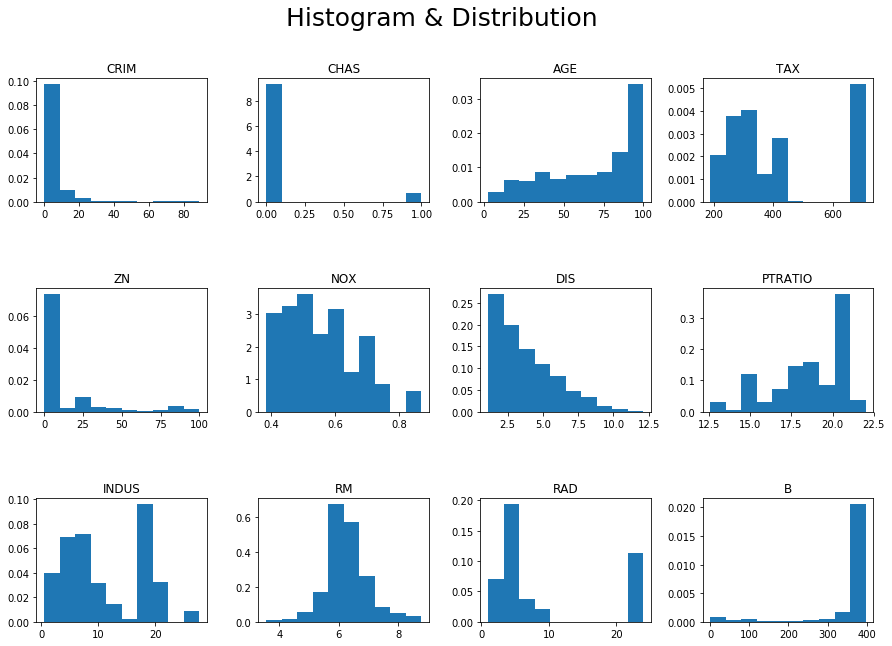

In [555]:
#find most likely distribution for each factor

fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize = (15,10))
rw, col = 0,0
for i in range(12):
    fign = ax[rw,col]
    fign.hist(data1.iloc[:,i], density = True)
    fign.set_title(data1.columns[i])
    
    rw += 1
    rw %= 3
    col += rw == 0
    
fig.subplots_adjust(hspace = 0.7, wspace = 0.3)
fig.suptitle("Histogram & Distribution", fontsize = 25)
fig.show()

In [499]:
#function that calculates various statistics
def stat_cal(df, i, split_ratio, calcor = True, drop = True):
    cori = -1
    if calcor:
        ex = df[i].mean()
        ey = df["MEDV"].mean()
        ox = np.sqrt(sum([(x - ex)**2 for x in df[i]]))
        oy = np.sqrt(sum([(y - ey)**2 for y in df["MEDV"]]))
        cori = np.sum([(x*y - ex*ey)/(ox*oy) for (x, y) in zip(df[i], df["MEDV"])])
        
    if drop:
        df = df.drop(i, axis = 1)
        
    n = int(df.shape[0]*split_ratio)
    Xtrain = df.iloc[n:].drop("MEDV", axis = 1)
    Xtrain.insert(0, 'ONE', [1]*(df.shape[0] - n))#don't include test cases
    Ytrain = df.loc[n:,"MEDV"]
    
    Xtest = df.iloc[:n,:].drop("MEDV", axis = 1)
    Xtest.insert(0, 'ONE', [1]*(n))#don't include test cases
    Ytest = df.loc[:n-1,"MEDV"]
    
    theta = np.linalg.inv(Xtrain.T.dot(Xtrain)).dot(Xtrain.T).dot(Ytrain)

    SSE = sum((Xtest.dot(theta) - Ytest)**2)
    SST = sum((Ytest - np.mean(Ytest))**2)
    R2 = 1 - SSE/SST
    R2adj = 1 - (SSE/(Xtrain.shape[0] - Xtrain.shape[1] - 1))/(SST/(Xtrain.shape[0] - 1))#adjust both SSE,SST for df
        
    return SSE, SST, R2, R2adj, cori
SSE, SST, R2, R2adj, cori = stat_cal(data, i, 0.2, calcor = False)
print(SSE, SST, R2, R2adj, cori)#a test

1204.665317425515 3520.0077227722763 0.6577662856725925 0.6463584951950124 -1


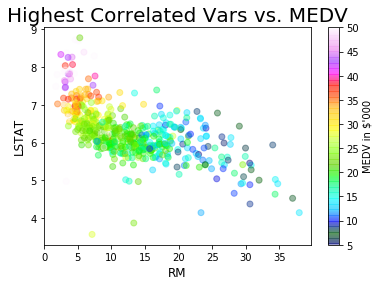

In [529]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

corrs = data.corr()["MEDV"]
corr_indx = corrs.apply(abs).sort_values(ascending = False)[1:].index#drops the "MEDV", the y

plt.figure()
plt.scatter(corr_indx[0], corr_indx[1], c = "MEDV", data = data1, alpha = 0.4, cmap=plt.get_cmap("gist_ncar"))
plt.colorbar().set_label("MEDV in $'000")
plt.xlabel(corr_indx[1], fontsize = 12)
plt.ylabel(corr_indx[0], fontsize = 12)
plt.title("Highest Correlated Vars vs. MEDV", fontsize = 20)
plt.show()

Text(0.5, 0.98, 'Plot of attributes vs. Home Value')

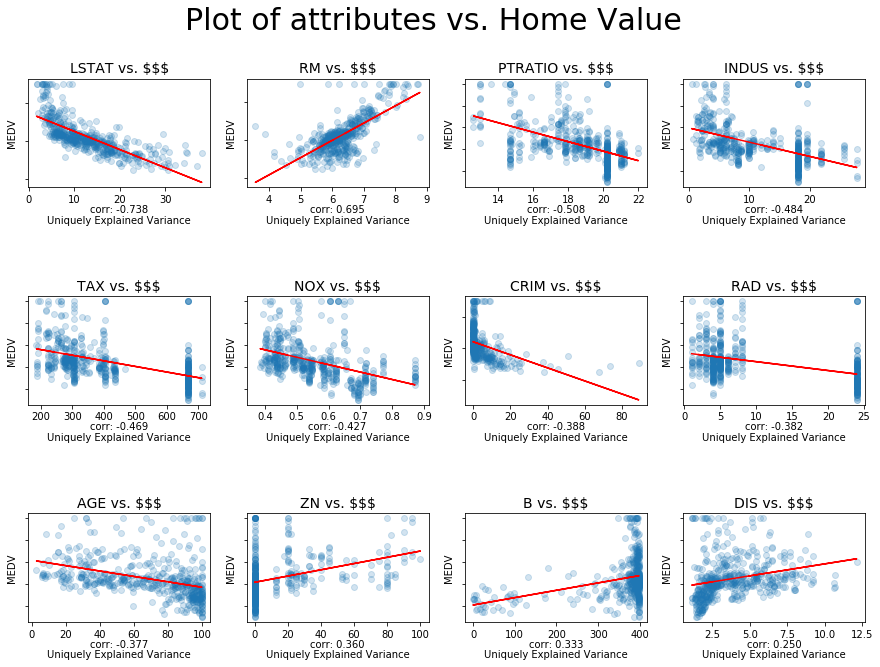

In [446]:
fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize = (15,10))
rw_loc = 0
col_loc = 0 

data_SSE, data_SST = stat_cal(data, i, 0.2, calcor = False, drop = False)[:2]

for i in corr_indx[:-1]:#eleven factors
    #print(rw_loc, col_loc)
    #print(ax[rw_loc, col_loc].plot(list(range(10)), list(range(10))))
    fign = ax[rw_loc, col_loc] 
    fign.scatter(data[i], data["MEDV"], alpha = 0.2)
    fign.axes.get_xaxis().set_visible(True)
    fign.axes.get_yaxis().set_visible(True)
    fign.set_ylabel('MEDV')
    fign.set_yticklabels([])
    fign.frame_on = False
    fign.set_title(i+ " vs. $$$", fontsize = 14)
    fign.text(0.5, -0.2, 'corr: ' + str("%.3f" % corrs[i]), horizontalalignment='center',
              verticalalignment='center', transform=fign.transAxes)
    fign.text(0.5, -0.3, 'Uniquely Explained Variance', horizontalalignment='center',
              verticalalignment='center', transform=fign.transAxes)
    line = sm.OLS(data["MEDV"],sm.add_constant(data[i])).fit()
    fign.plot(data[i], line.params[0] + line.params[1]*data[i],'r')
    #next step is to add the amount of unique variance explained by this factor
    SSE, SST, R2, R2adj, cori = stat_cal(data, i, 0.2, drop = True)
    iSSE, iSST = stat_cal(data.loc[:,[i, "MEDV"]], i, 0.2, drop = False)[:2]
    
    #math below is wrong, need to update
    #print("Variance explained: ", cori)#variance explained by everthing(prediction on all others + noise) but this factor/total error
    #print("Uniquly explain % of total explained Variance", ((data_SST - data_SSE) - SSE)/(data_SST))
    #print(i, R2, R2adj, SSE, SST, cori, "\n")
    
    col_loc += 1
    col_loc %= 4
    if col_loc == 0:
        rw_loc += 1
fig.subplots_adjust(hspace = 0.75)
fig.suptitle('Plot of Attributes vs. Home Value', fontsize=30)

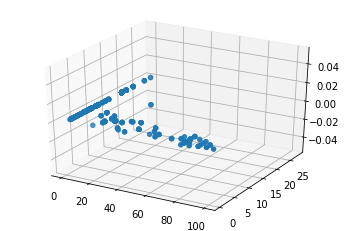

In [534]:
#see how being along the chase river changes the price distribution? Graphically
#next plot pdfs of (feature, price). 3d

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(data.iloc[:,1], data.iloc[:,2])
#how to calculate the pdf of this function
i = 'LSTAT'
pnts_d = [[x, y] for x,y in zip(data.loc[:,i], data.loc[:,"MEDV"])]
#print(pnts_d)
#doesn't work yet either
joint_prob, edges = np.histogramdd(np.array(data1[i], data1["MEDV"]), bins = 3)

#ax.scatter(data[:,i], data[:,"MEDV"], zs = data["MEDV"], alpha = 0.2)

In [420]:
np.random.randn(3, 3)
#list([data.iloc[:3,1], data.iloc[:3,2]]))

array([ 0.11438764, -0.21331613,  0.28575314])

In [2]:
#how to include this in some pipeline?
#######################ONLY run once
cat_encoder = OneHotEncoder(sparse = False)
cat_var_names = ["RAD","CHAS"]
cat_vars = data1[cat_var_names]
housing_cat1hot = cat_encoder.fit_transform(cat_vars)#represents 11 binary columns of "YES/NO" for a specific radial then chase river  

cat_names = []
for i in range(len(cat_encoder.categories_)):
    for j in cat_encoder.categories_[i]:
        cat_names.append(str(cat_var_names[i]) + str(int(j)))

cats = pd.DataFrame(data = housing_cat1hot, columns = cat_names)
data1 = pd.merge(data1, cats, left_on=data1.index, right_on=cats.index,how='left')
cat_var_names.append("key_0")#gets included w/ merge
data1.drop(labels = cat_var_names, axis = 1)
print("")

c:\programdata\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [4]:
#should make this a pipeline
def cat_vars(lst):
    out = []
    for i in lst:
        cat_vars= data1[[i]]
        cat_encoder = OneHotEncoder(sparse = False)
        housing_cat1hot = cat_encoder.fit_transform(cat_vars)
        out.append(housing_cat1hot)
    return(out)
cat_atts = ["RAD", "CHAS"]
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([("cat", OneHotEncoder(), cat_atts)])
data2 = full_pipeline.fit_transform(data1)#just has catagorical variables? figure this out. Are the columns of arrays or many columns?
print(data1.shape)
print(data2.shape)

(505, 26)
(505, 11)


c:\programdata\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [208]:
from sklearn.model_selection import train_test_split
#do I need to keep a segment of data away from the rest perminantly?
from sklearn.linear_model import LinearRegression
y = data["MEDV"]
X = data.drop("MEDV", axis = 1)
X.insert(0,'ONE',[1]*X.shape[0])#prepend column of one's  for theta0

In [255]:
#manually calculate the best linear regression
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
SSE = sum((y - X.dot(theta))**2)
SST = sum((y - np.sum(y))**2)
R2 = 1 - SSE/SST
print(R2)#very good fit, but included too much

0.9999998304174832
0.7341169738071796


In [288]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
theta = np.linalg.inv(x_train.T.dot(x_train)).dot(x_train.T).dot(y_train)
SSE = sum((y_test - x_test.dot(theta))**2)
SST = sum((y_test - sum(y_test))**2)
R2 = 1 - SSE/SST
print("R2: ", R2)#this is >0.99999? why? regardless of how much I split my test data? need to adj R^2
MSE = SSE/(X.shape[0] - X.shape[1])#added the theta0 parameter for MEDV which was taken out
print("MSE: ", MSE)
Radj = 1 - MSE/(np.std(y_test)**2)
print("Radj", Radj)


R2:  0.9999959741675424
MSE:  4.076674788913218
Radj 0.9565809649641454


In [300]:
#automatically build model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
reg = lin_reg.fit(x_train, y_train)
print("reg score: ", reg.score(x_test, y_test))#why does this perform much worse than Radj?

from sklearn.metrics import mean_squared_error
print("MSE: ", mean_squared_error(y_test, x_test.dot(reg.coef_) + reg.intercept_))
np.mean((x_test.dot(reg.coef_) + reg.intercept_ - y_test)**2)
#the reason you have to include reg.intercept_ despite having the column of 1's in X is that theta0
#in the regession = 0, as that term has no impact on the final outcome of the equation

reg score:  0.7889233049247124
MSE:  19.81829031045874


19.818290310458735

1591.1151998435512